In [1]:
import numpy as np
def simulate_logistic(x, b):
    z = x.dot(b)
    p = 1/(1+np.exp(-z))
    return np.random.binomial(1., p).astype(np.float32)

def get_X(n,p,seed=999):
    np.random.seed(seed)
    x1 = np.random.binomial(1,p,n)
    x2 = np.random.binomial(1,p,n)
    x3 = x2
    return np.vstack([x1, x2, x3]).T.astype(np.float32)

seed = 999
b = [0,1,0]
X = get_X(1000,0.2,seed)
y = simulate_logistic(X,b)

In [2]:
iteration = 2000
tune_prop = 0.1
n_chain = 10
n_thread = 4

pi0 = 0.051366009925488
mu = 0.783230896500752
sigma = 0.816999481742865
lower = -2.94
upper = 0

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import pymc4 as pm4
from pymc4.mcmc.samplers import NUTS, RandomWalkM

@pm4.model
def bvsr_pm4(y, X, pi0=0.5, mu=0, sigma=1, lower=-1, upper=1):
    xi = yield pm4.Bernoulli('xi', pi0 * tf.ones(X.shape[1], 'float32'))
    # beta_offset = 0.1
    beta_offset = yield pm4.Normal('beta_offset', tf.zeros(X.shape[1], 'float32'), tf.ones(X.shape[1], 'float32'))
    beta = yield pm4.Deterministic("beta", mu + beta_offset * sigma)
    alpha_offset = yield pm4.Uniform("alpha_offset", -1, 1)
    # alpha_offset = 0.9
    alpha = yield pm4.Deterministic("alpha", lower + (alpha_offset + 1) / 2 * (upper - lower))
    
    p = tf.linalg.matvec(X, tf.cast(xi, tf.float32) * beta)
    yield pm4.Bernoulli('y_obs', tf.math.sigmoid(p+alpha), observed = y)

tf.config.threading.set_intra_op_parallelism_threads(n_thread)

m4 = bvsr_pm4(y, tf.constant(X), pi0, mu, sigma, lower, upper)

In [4]:
%%time
trace4 = pm4.sample(
    m4, step_size=0.01, num_chains=n_chain, num_samples=iteration,
    burn_in=int(tune_prop*iteration), nuts_kwargs={},
    xla=True, use_auto_batching=True,
    sampler_type="compound", 
    sampler_methods=[
        ("xi", RandomWalkM),
    ]
)

CPU times: user 1min 52s, sys: 5.81 s, total: 1min 58s
Wall time: 1min 30s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0d449cb70>,
      dtype=object)

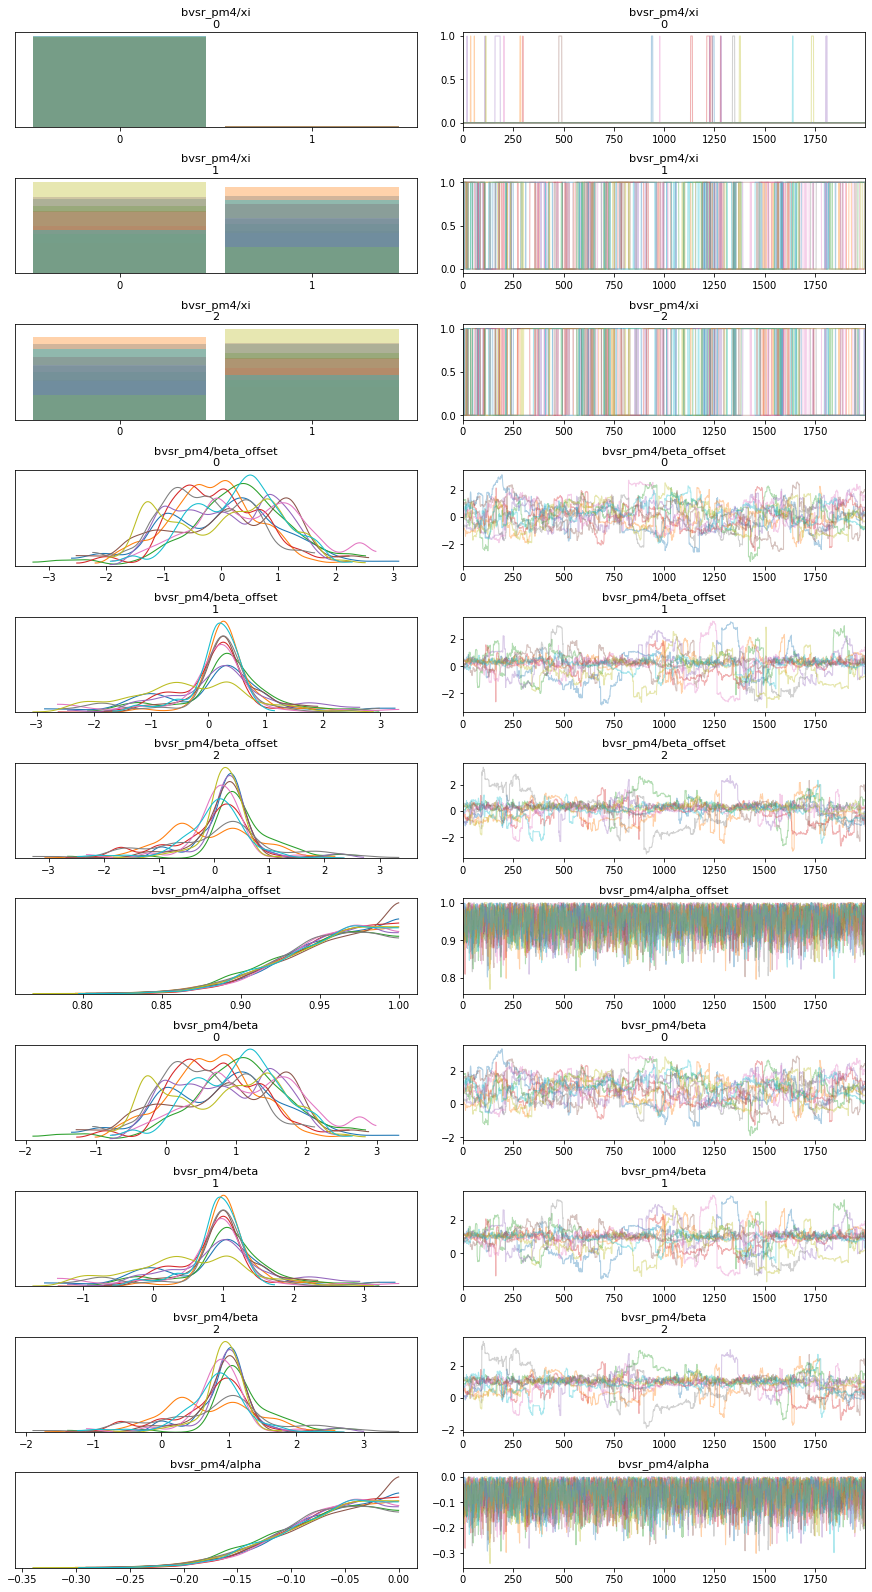

In [5]:
import arviz as az
az.plot_trace(trace4)

In [6]:
tf.reduce_sum(trace4.posterior["bvsr_pm4/xi"], axis=[0,1]) / 20000

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.0072 , 0.4919 , 0.52185])>